In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import sqrt

import DataAid
import Neros

In [2]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
# Get the galaxies we want from each source
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

# chi squared function
def chiSquared(observed, expected, error):
    chiSq = 0
    
    for i in range(len(observed)):
        chiSq = chiSq + (((observed[i] - expected[i])**2) / (error[i]**2))
    
    return chiSq / len(observed)

## Create the Milky Way interpolation function

In [3]:
MW_rad = MWXueSofue[:,0]
MW_vLum = MWXueSofue[:,1]
# Interpolation function
MW_vLum_interp_func = interp1d(MW_rad, MW_vLum, kind='cubic')

## Running VNeros on every galaxy
We calculate vNeros for each galaxy and then plot the ratio between vNeros and the galaxy's vObs

[0.06888476 0.07533799 0.08474777 0.09296343 0.09989528 0.10507261
 0.10939166 0.11382585 0.11769116 0.12139122 0.12556305 0.12994814
 0.13488753 0.14020597 0.14545396 0.15091474 0.15603629 0.16129554
 0.16650409 0.17178824 0.17657678 0.18121661 0.19334815 0.20310515
 0.21113631 0.21811814 0.22440415 0.23472525 0.24245085 0.24825803
 0.25257459 0.2564495  0.25943621 0.26219089 0.26457678 0.26653593
 0.26837745 0.26989854 0.27138509 0.27276345 0.27394489 0.27515197
 0.27618881]
[3.22951491e-07 7.90630694e-07 1.01699123e-06 1.15355556e-06
 1.25242611e-06 1.32589580e-06 1.38322095e-06 1.43335914e-06
 1.47414487e-06 1.50949982e-06 1.54164010e-06 1.56852280e-06
 1.59358625e-06 1.61720965e-06 1.63827255e-06 1.65827529e-06
 1.67575210e-06 1.69263962e-06 1.70838627e-06 1.72357843e-06
 1.73704054e-06 1.75008129e-06 1.78557721e-06 1.81631659e-06
 1.84266164e-06 1.86544103e-06 1.88548191e-06 1.91851093e-06
 1.94481537e-06 1.96634088e-06 1.98278156e-06 1.99754413e-06
 2.00900627e-06 2.01960426e-06

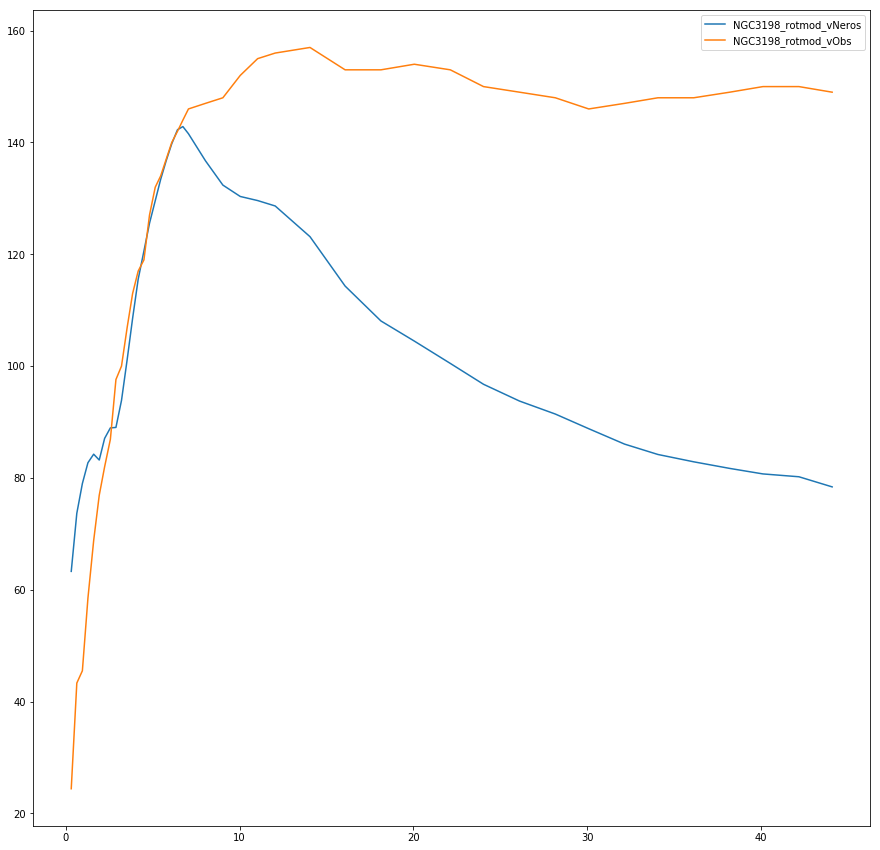

In [4]:
vLcmList = []
f, ax = plt.subplots(1, figsize=(15,15))
for galaxyName in sparcGalaxies:
    # change the name in "" to print only that galaxy
    if (galaxyName != "NGC3198_rotmod"):
        continue
    
    galaxy = np.array(sparcGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break
    # Run vLCM
    vLcm = Neros.vLcm(galaxy_rad, MW_vLum_interp_func(galaxy_rad), galaxy_vLum)
    vLcmList.append(vLcm)
    vNeros = Neros.vNeros(galaxy_vLum, vLcm, 1)
    ratio = vNeros/galaxy_vObs
    # plot
    ax.plot(galaxy_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vObs, label="{}_vObs".format(galaxyName))
ax.legend(loc="upper right")

## Fitting Galaxies

[0.67317906 0.69643615 0.73492783 0.7759232  0.81494396 0.84992408
 0.88576402 0.92838465 0.97500121 1.02033557 1.06154906 1.09631644
 1.17254234 1.22053146 1.2501154  1.26863159 1.28093095 1.28940918
 1.29541113 1.29978952 1.30304814 1.30541306 1.3070896  1.3082793
 1.30913591 1.30974508 1.31016268 1.31045871 1.3106626  1.31079505
 1.31087755 1.31093262 1.31097503 1.31100614]
[3.22951491e-07 7.90630694e-07 1.01699123e-06 1.15355556e-06
 1.24976008e-06 1.32375268e-06 1.38311989e-06 1.43184281e-06
 1.47281562e-06 1.50831506e-06 1.53964763e-06 1.56754362e-06
 1.63750413e-06 1.69252008e-06 1.73743363e-06 1.77470591e-06
 1.80605671e-06 1.83295290e-06 1.85627430e-06 1.87667301e-06
 1.89459871e-06 1.91047510e-06 1.92464572e-06 1.93732659e-06
 1.94870429e-06 1.95897642e-06 1.96829914e-06 1.97677118e-06
 1.98450196e-06 1.99158663e-06 1.99810166e-06 2.00409714e-06
 2.00962546e-06 2.01474815e-06]
[2.17404181e-07 5.50623797e-07 7.47415156e-07 8.95070520e-07
 1.01848443e-06 1.12508927e-06 1.225117

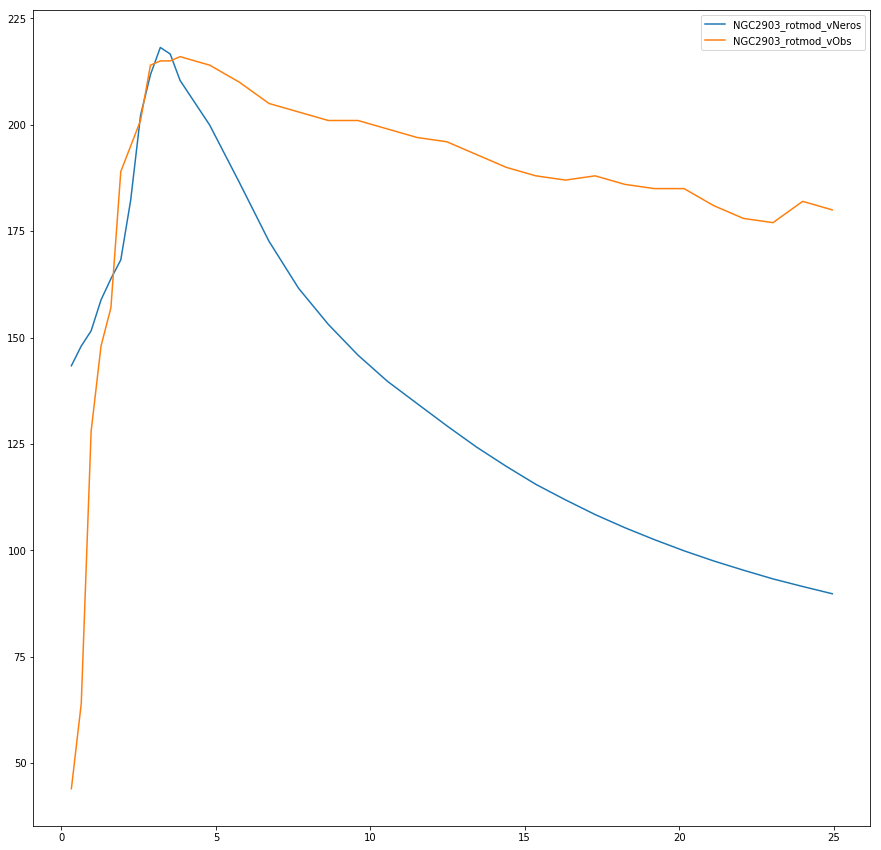

In [5]:
file = open('imported-data/data.csv', 'w')
file.write('{0},{1},{2}\n'.format("Galaxy", "Alpha", "vLum"))

f, ax = plt.subplots(1, figsize=(15,15))

# Fit function
def simple(independents,alpha,vLumFreeParam):
    # Parse out data for the galaxy
    rad,vLum = independents
    # Apply the vLum free param to the data
    vLum = vLum*vLumFreeParam
    # Calc vLCM with alpha free param
    vLcm = Neros.vLcm(rad, MW_vLum_interp_func(rad), vLum,)
    # Calc and return vNeros
    return Neros.vNeros(vLum, vLcm, alpha)

# Parse out data

for galaxyName in sparcGalaxies:
    # change the name in "" to print only that galaxy
    if (galaxyName != "NGC2903_rotmod"):
        continue
    
    galaxy = np.array(sparcGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break
            
    # Run fitter
    vals, cov = curve_fit(simple,(galaxy_rad, galaxy_vLum),galaxy_vObs)
    fittedAlpha = vals[0]
    fittedVLumFreeParam = vals[1]
    
    vExpected = simple((galaxy_rad, galaxy_vLum), fittedAlpha, fittedVLumFreeParam)
    
    print('{0}\t{1}\t{2}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam))
    print(chiSquared(galaxy_vObs, vExpected, galaxy_error))
    file.write('{0},{1},{2}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam))
    
    # Run vLCM
    vLcm = Neros.vLcm(galaxy_rad, MW_vLum_interp_func(galaxy_rad), galaxy_vLum * fittedVLumFreeParam)
    vLcmList.append(vLcm)
    vNeros = Neros.vNeros(galaxy_vLum * fittedVLumFreeParam, vLcm, 1)
    ratio = vNeros/galaxy_vObs
    # plot
    ax.plot(galaxy_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vObs, label="{}_vObs".format(galaxyName))
ax.legend(loc="upper right")